# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'dgemm_prediction/3/grenoble_2019-08-16_1879237.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'transA', 'transB', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 0)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°0 from dgemm_prediction/3/grenoble_2019-08-16_1879237.zip: 4095170 lines
7865


,jobid,function,start,end,rank,m,n,k,lda,ldb,ldc,layout,transA,transB,duration,exp_id
0,1879237,dgemm,0.156588,0.156635,0,6654,2,2,6656.0,512.0,6656.0,102.0,111.0,112.0,0.000047,0
1,1879237,dgemm,0.156837,0.156891,0,6652,4,4,6656.0,512.0,6656.0,102.0,111.0,112.0,0.000054,0
2,1879237,dgemm,0.157094,0.157117,0,6650,2,2,6656.0,512.0,6656.0,102.0,111.0,112.0,0.000023,0
3,1879237,dgemm,0.157281,0.157408,0,6648,8,8,6656.0,512.0,6656.0,102.0,111.0,112.0,0.000127,0
4,1879237,dgemm,0.157575,0.157597,0,6646,2,2,6656.0,512.0,6656.0,102.0,111.0,112.0,0.000022,0


For the record, the different numerical values for the arguments of dgemm are (according to my tests):
```
CblasColMajor: 102
CblasRowMajor: 101
CblasNoTrans : 111
CblasTrans   : 112
```

In [3]:
traces_calibration = read_csv('dgemm_prediction/3/grenoble_2019-08-16_1879250.zip', 'result.csv')
traces_calibration = traces_calibration[traces_calibration['core'] == 0]
traces_calibration = traces_calibration.reset_index(drop=True)
print(len(traces_calibration))
traces_calibration.head()

7865


,function,m,n,k,lda,ldb,ldc,timestamp,duration,core,jobid
0,dgemm,6654,2,2,6656,512,6656,375.087669,0.000028,0,1879250
1,dgemm,6652,4,4,6656,512,6656,375.087727,0.000069,0,1879250
2,dgemm,6650,2,2,6656,512,6656,375.087799,0.000022,0,1879250
3,dgemm,6648,8,8,6656,512,6656,375.087824,0.000120,0,1879250
4,dgemm,6646,2,2,6656,512,6656,375.087947,0.000022,0,1879250


In [4]:
sizelist_hpl = [list(t[1]) for t in traces[['m', 'n', 'k', 'lda', 'ldb', 'ldc']].iterrows()]
sizelist_cal = [list(t[1]) for t in traces_calibration[['m', 'n', 'k', 'lda', 'ldb', 'ldc']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [5]:
traces['duration_calibration'] = traces_calibration['duration']
traces['mnk'] = traces.m * traces.n * traces.k

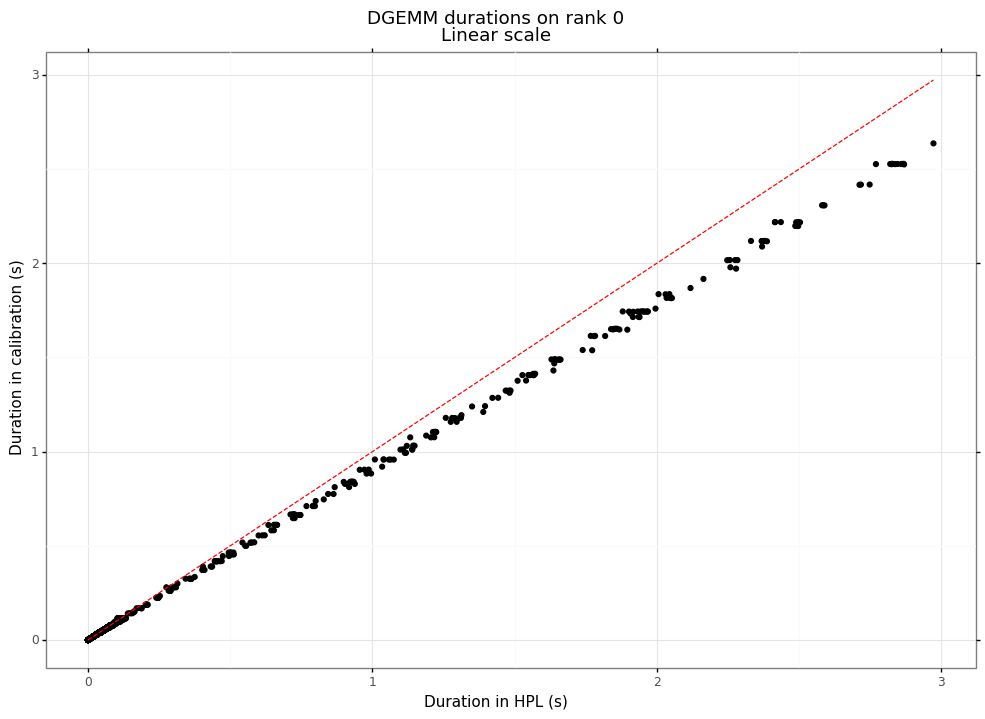

<ggplot: (-9223363308346277909)>


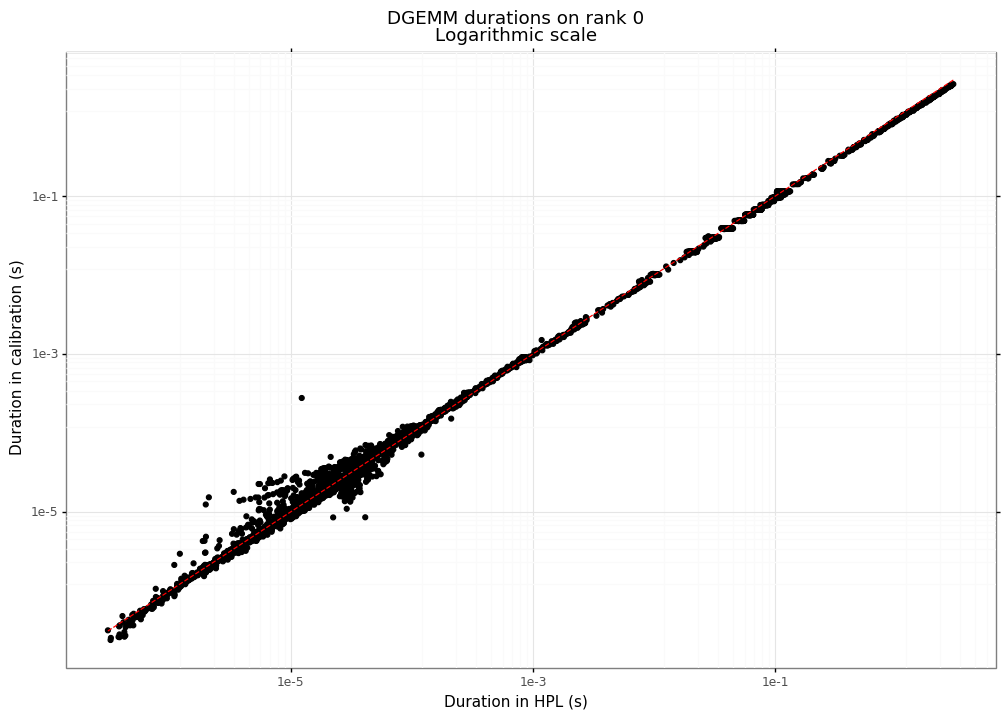

<ggplot: (8728506316008)>


In [6]:
plot = ggplot(traces, aes(x='duration', y='duration_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on rank 0\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [7]:
traces['gflops_hpl'] = 2*traces.mnk / traces['duration'] * 1e-9
traces['gflops_calibration'] = 2*traces.mnk / traces['duration_calibration'] * 1e-9

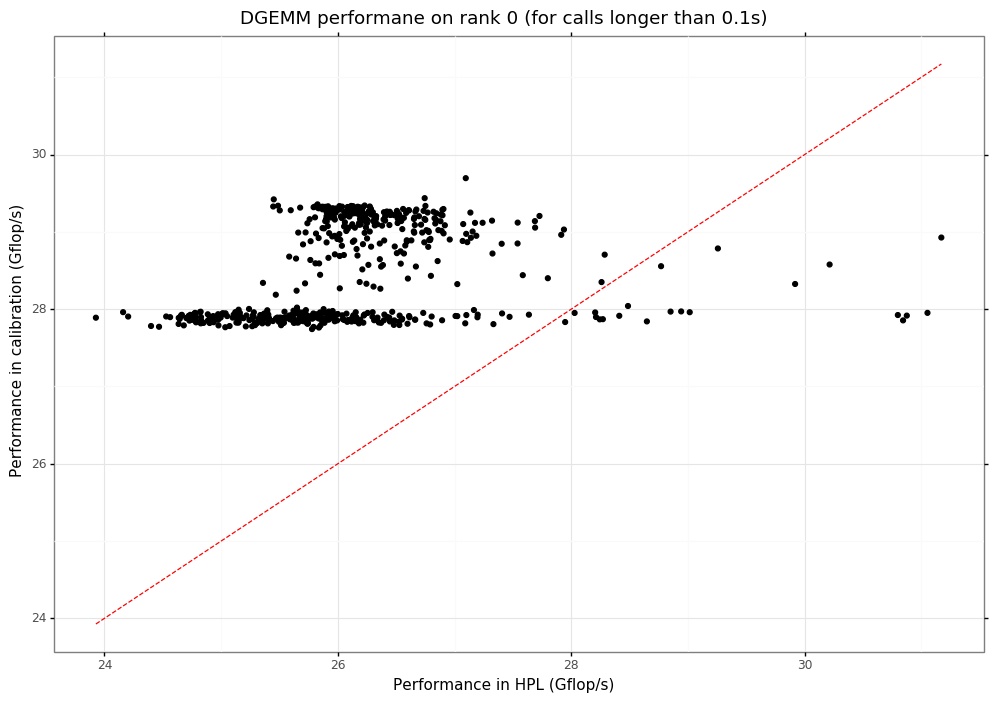

<ggplot: (8728501520602)>

In [8]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='gflops_hpl', y='gflops_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='gflops_hpl', y='gflops_hpl'), color='red', linetype='dashed')
plot = plot + xlab('Performance in HPL (Gflop/s)') + ylab('Performance in calibration (Gflop/s)')
plot + ggtitle('DGEMM performane on rank 0 (for calls longer than 0.1s)')

In [9]:
summary = traces[['duration', 'duration_calibration', 'mnk']].sum()
summary['gflops'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_calibration'] = 2*summary['mnk'] / summary['duration_calibration'] * 1e-9
summary['error'] = (summary['duration_calibration'] - summary['duration']) / summary['duration']
summary

duration                4.145724e+02
duration_calibration    3.757441e+02
mnk                     5.426816e+12
gflops                  2.618031e+01
gflops_calibration      2.888571e+01
error                  -9.365869e-02
dtype: float64